In [1]:
!pip install torchsummary
import torch
import torchvision
from torchsummary import summary


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10 = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train=True)



100%|██████████| 170498071/170498071 [00:04<00:00, 34233346.37it/s]


Extracting Datasets/cifar-10-python.tar.gz to Datasets


In [4]:
dataloader = DataLoader(CIFAR10, batch_size= 256,shuffle= True)

In [5]:
CIFAR10.__getitem__(0)[0].shape

torch.Size([3, 32, 32])

In [6]:
import torch
import torchvision.models as models
from torchvision.models import AlexNet_Weights
import torch.nn as nn
from torchsummary import summary

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Importing the modified AlexNet model
def modified_alexnet(weights=None, progress=True, num_classes=1000):
    model = models.AlexNet(num_classes=num_classes)
    if weights is not None:
        state_dict = weights.get_state_dict(progress=progress)
        model.load_state_dict(state_dict)

    # Adjusting the model to fit 32x32 input
    model.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),  # smaller kernel, stride and increased padding
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 192, kernel_size=3, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

    # Reducing the number of pooling layers
    # The fully connected layers can remain unchanged or be adapted based on your specific needs
    return model

# Load the modified AlexNet
alexnet_mod = modified_alexnet(weights=AlexNet_Weights.DEFAULT).to(device)

# Modifying the classifier to remove the last layer
alexnet_mod.classifier = nn.Sequential(*list(alexnet_mod.classifier.children())[:-1])

# Printing the modified model summary
summary(alexnet_mod, (3, 32, 32), device=str(device))


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 269MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 34, 34]           1,792
              ReLU-2           [-1, 64, 34, 34]               0
         MaxPool2d-3           [-1, 64, 17, 17]               0
            Conv2d-4          [-1, 192, 19, 19]         110,784
              ReLU-5          [-1, 192, 19, 19]               0
         MaxPool2d-6            [-1, 192, 9, 9]               0
            Conv2d-7            [-1, 384, 9, 9]         663,936
              ReLU-8            [-1, 384, 9, 9]               0
            Conv2d-9            [-1, 256, 9, 9]         884,992
             ReLU-10            [-1, 256, 9, 9]               0
           Conv2d-11            [-1, 256, 9, 9]         590,080
             ReLU-12            [-1, 256, 9, 9]               0
AdaptiveAvgPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [7]:
import torch.nn as nn
class model(nn.Module):
    def __init__(self, classifier, bit_length = 32):
        super(model, self).__init__()
        self.classifier = classifier

        # self.fc1 = nn.Sequential()
        # self.fc1.add_module('fc6_s1',nn.Linear(512, 1024)) #256*3*3
        # self.fc1.add_module('relu6_s1',nn.ReLU(inplace=True))
        # self.fc1.add_module('drop6_s1',nn.Dropout(p=0.5))

        # self.fc2 = nn.Sequential()
        # self.fc2.add_module('fc2',nn.Linear(1024, 512))
        # self.fc2.add_module('relu7',nn.ReLU(inplace=True))
        # self.fc2.add_module('drop7',nn.Dropout(p=0.5))

        # self.fc3 = nn.Sequential()
        # self.fc3.add_module('fc8',nn.Linear(512, hash_length))
        # self.fc3.add_module('tanh', nn.Tanh())
        self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(4096, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(2048, 2048),
                nn.ReLU(inplace=True),
                nn.Linear(2048, bit_length),
                # nn.Tanh()
            )
    def forward(self, x):
        x = self.classifier(x)
        # x = torch.flatten(x, start_dim= 1, end_dim= 3)
        x = self.fc(x)
        # x = self.fc2(x)
        # x = self.fc3(x)
        return x


In [8]:
alexnet_mod = model(alexnet_mod, bit_length= 16)
alexnet_mod.to(device)

model(
  (classifier): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): ReLU(inplace=True)

In [9]:
image, labels = next(iter(dataloader))
image = image.to(device)
labels = labels.to(device)

# output = vgg(image)
output  = alexnet_mod(image)
output.shape

torch.Size([256, 16])

In [10]:
import torch.nn.functional as F
class MSE_loss(nn.Module):
    def __init__(self):
        super(MSE_loss, self).__init__()

    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)

        theta= 1/2 * torch.matmul(U, U.T)
        loss = torch.sum((S - theta) ** 2)
        return loss

In [11]:
def dpsh_loss(b, labels):
    """
    DPSH loss function for pairwise labels in supervised hashing.

    Args:
    b (torch.Tensor): The batch of binary codes, shape [batch_size, code_length], each element should be -1 or 1.
    S (torch.Tensor): The matrix of pairwise labels, shape [batch_size, batch_size],
                      S[i, j] = 1 if i and j are similar, 0 otherwise.

    Returns:
    torch.Tensor: The computed loss value.
    """
    # Ensure b is a float tensor for matrix multiplication
    L = F.one_hot(labels).to(torch.float64)
    S = torch.matmul(L, L.T)
    b = b.float()

    # Compute the matrix of inner products
    sim_matrix = 0.5 * torch.matmul(b, b.t())

    # Calculate the DPSH loss
    positive_term = S * sim_matrix
    log_term = torch.log(1 + torch.exp(sim_matrix))
    loss = -torch.sum(positive_term - log_term)

    return loss


In [12]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_orthogonal_targets(num_classes, num_bits):
  # Generate a random matrix of shape (num_classes, num_bits)
	# We'll use a slight modification to ensure it's correct:
	# if num_bits < num_classes, QR might not work as expected because QR returns min(num_classes, num_bits) columns.
	# We need to ensure the matrix is at least square or that num_bits >= num_classes.
    targets = np.random.randn(max(num_classes, num_bits), num_bits)
    q, _ = np.linalg.qr(targets)
	# Make sure to select only the first num_classes rows after QR decomposition if num_bits < num_classes.
    q = q[:num_classes]
    binary_targets = np.sign(q)
    return torch.tensor(binary_targets, dtype=torch.float32, device=device)

class OrthoHashLoss(torch.nn.Module):
    def __init__(self, num_classes, num_bits):
        super(OrthoHashLoss, self).__init__()
        # Initialize binary orthogonal targets and send them to the specified device
        self.O = generate_orthogonal_targets(num_classes, num_bits).to(device)

    def forward(self, v, labels):
        # Ensure v is normalized
        v_norm = F.normalize(v, p=2, dim=1).to(device)
        # Compute the logits by dot product of normalized codes and orthogonal targets
        logits = torch.mm(v_norm, self.O.t())
        # Cross-entropy loss between predicted logits and actual class labels
        return F.cross_entropy(logits, labels)

# Example usage
num_classes = 10  # Number of classes
num_bits = 32	# Dimension of the binary hash codes
loss_func = OrthoHashLoss(num_classes, num_bits)
v = torch.randn(64, num_bits).to(device)  # Example batch of continuous codes
labels = torch.randint(0, num_classes, (64,)).to(device)  # Example batch of labels
loss = loss_func(v, labels)
print("Loss:", loss.item())





Loss: 2.615386962890625


In [13]:
class log_loss(nn.Module):
    def __init__(self):
        super(log_loss, self).__init__()

    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)


        theta= 1/2 * torch.matmul(U, U.T)

        J =  - (S * theta - torch.log(1 +   torch.exp(theta)))
        loss = 1/ 2 * torch.sum(J)
        return loss

In [14]:
# vgg = models.vgg16(weights= VGG16_Weights.DEFAULT).to(device)
# vgg.classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])

# vgg_model = model(vgg, bit_length= 16).to(device)

In [15]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Assuming 'alexnet_mod' is already defined and loaded properly
num_classes = 10  # Set the number of classes according to your model's output
num_bits = 16     # Set the dimension of the hash codes

# Lock gradients for all parameters except the last classifier layer
# for name, param in vgg_model.named_parameters():
#     if 'classifier' not in name:  # Adjust this condition based on your model architecture
#         param.requires_grad = False

for param in alexnet_mod.classifier.parameters():
        param.requires_grad = False

# Assuming the last fully connected layer is named 'fc' and you want to train it
optimizer = optim.Adam(alexnet_mod.fc.parameters(), lr=0.001)
eta = 0.1
epochs = 50

# Initialize the custom loss function
loss_fn = OrthoHashLoss(num_classes, num_bits)
# loss_fn = MSE_loss()

loss_list = []

for epoch in range(epochs):
    loop = tqdm(dataloader)
    total_loss = 0
    reg_loss = 0

    for data in loop:
        images, labels = data

        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        # forward
        U = alexnet_mod(images)

        # Calculate regularization term
        reg = torch.sum((torch.sgn(U) - U)**2)

        # Calculate loss
        loss = loss_fn(U, labels)
        total_loss += loss.item()

        # backward + optimize
        loss.backward()
        optimizer.step()

        loop.set_postfix(epoch=epoch, loss=loss.item())

    # Compute average losses for logging
    avg_total_loss = total_loss / len(loop)

    loss_list.append(avg_total_loss)

    # Optionally log the progress at certain intervals
    print(f'Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_total_loss:.4f}')

print('Finished Training')


100%|██████████| 196/196 [00:16<00:00, 11.53it/s, epoch=0, loss=2.27]


Epoch [1/50], Avg Loss: 2.3098


100%|██████████| 196/196 [00:16<00:00, 12.03it/s, epoch=1, loss=2.05]


Epoch [2/50], Avg Loss: 2.1652


100%|██████████| 196/196 [00:16<00:00, 11.91it/s, epoch=2, loss=2.09]


Epoch [3/50], Avg Loss: 2.0755


100%|██████████| 196/196 [00:16<00:00, 12.12it/s, epoch=3, loss=2.11]


Epoch [4/50], Avg Loss: 2.0542


100%|██████████| 196/196 [00:16<00:00, 12.07it/s, epoch=4, loss=2]   


Epoch [5/50], Avg Loss: 2.0431


100%|██████████| 196/196 [00:16<00:00, 12.20it/s, epoch=5, loss=2]   


Epoch [6/50], Avg Loss: 2.0299


100%|██████████| 196/196 [00:16<00:00, 12.13it/s, epoch=6, loss=1.95]


Epoch [7/50], Avg Loss: 2.0186


100%|██████████| 196/196 [00:16<00:00, 12.08it/s, epoch=7, loss=1.97]


Epoch [8/50], Avg Loss: 2.0155


100%|██████████| 196/196 [00:16<00:00, 11.94it/s, epoch=8, loss=1.96]


Epoch [9/50], Avg Loss: 2.0012


100%|██████████| 196/196 [00:16<00:00, 12.14it/s, epoch=9, loss=1.86]


Epoch [10/50], Avg Loss: 2.0011


100%|██████████| 196/196 [00:16<00:00, 12.05it/s, epoch=10, loss=2]   


Epoch [11/50], Avg Loss: 1.9976


100%|██████████| 196/196 [00:16<00:00, 12.09it/s, epoch=11, loss=2.06]


Epoch [12/50], Avg Loss: 1.9884


100%|██████████| 196/196 [00:16<00:00, 12.06it/s, epoch=12, loss=2]   


Epoch [13/50], Avg Loss: 1.9854


100%|██████████| 196/196 [00:16<00:00, 12.17it/s, epoch=13, loss=1.89]


Epoch [14/50], Avg Loss: 1.9861


100%|██████████| 196/196 [00:16<00:00, 12.03it/s, epoch=14, loss=1.96]


Epoch [15/50], Avg Loss: 1.9803


100%|██████████| 196/196 [00:16<00:00, 12.13it/s, epoch=15, loss=1.87]


Epoch [16/50], Avg Loss: 1.9822


100%|██████████| 196/196 [00:16<00:00, 12.11it/s, epoch=16, loss=1.9] 


Epoch [17/50], Avg Loss: 1.9809


100%|██████████| 196/196 [00:16<00:00, 12.22it/s, epoch=17, loss=1.88]


Epoch [18/50], Avg Loss: 1.9784


100%|██████████| 196/196 [00:16<00:00, 12.14it/s, epoch=18, loss=2.02]


Epoch [19/50], Avg Loss: 1.9731


100%|██████████| 196/196 [00:16<00:00, 12.22it/s, epoch=19, loss=2.02]


Epoch [20/50], Avg Loss: 1.9731


100%|██████████| 196/196 [00:16<00:00, 12.08it/s, epoch=20, loss=2]   


Epoch [21/50], Avg Loss: 1.9769


100%|██████████| 196/196 [00:16<00:00, 12.15it/s, epoch=21, loss=1.9] 


Epoch [22/50], Avg Loss: 1.9689


100%|██████████| 196/196 [00:16<00:00, 12.20it/s, epoch=22, loss=2.04]


Epoch [23/50], Avg Loss: 1.9681


100%|██████████| 196/196 [00:16<00:00, 12.13it/s, epoch=23, loss=1.96]


Epoch [24/50], Avg Loss: 1.9615


100%|██████████| 196/196 [00:16<00:00, 12.15it/s, epoch=24, loss=2.05]


Epoch [25/50], Avg Loss: 1.9702


100%|██████████| 196/196 [00:16<00:00, 12.17it/s, epoch=25, loss=1.84]


Epoch [26/50], Avg Loss: 1.9681


100%|██████████| 196/196 [00:15<00:00, 12.26it/s, epoch=26, loss=1.92]


Epoch [27/50], Avg Loss: 1.9640


100%|██████████| 196/196 [00:16<00:00, 12.09it/s, epoch=27, loss=1.93]


Epoch [28/50], Avg Loss: 1.9632


100%|██████████| 196/196 [00:16<00:00, 12.17it/s, epoch=28, loss=1.92]


Epoch [29/50], Avg Loss: 1.9623


100%|██████████| 196/196 [00:16<00:00, 12.16it/s, epoch=29, loss=2.07]


Epoch [30/50], Avg Loss: 1.9623


100%|██████████| 196/196 [00:16<00:00, 12.23it/s, epoch=30, loss=2.15]


Epoch [31/50], Avg Loss: 1.9594


100%|██████████| 196/196 [00:16<00:00, 12.06it/s, epoch=31, loss=2.02]


Epoch [32/50], Avg Loss: 1.9603


100%|██████████| 196/196 [00:16<00:00, 12.13it/s, epoch=32, loss=1.95]


Epoch [33/50], Avg Loss: 1.9576


100%|██████████| 196/196 [00:16<00:00, 12.01it/s, epoch=33, loss=2.11]


Epoch [34/50], Avg Loss: 1.9576


100%|██████████| 196/196 [00:16<00:00, 12.22it/s, epoch=34, loss=1.9] 


Epoch [35/50], Avg Loss: 1.9551


100%|██████████| 196/196 [00:16<00:00, 12.08it/s, epoch=35, loss=1.87]


Epoch [36/50], Avg Loss: 1.9598


100%|██████████| 196/196 [00:16<00:00, 12.23it/s, epoch=36, loss=1.92]


Epoch [37/50], Avg Loss: 1.9555


100%|██████████| 196/196 [00:16<00:00, 12.03it/s, epoch=37, loss=1.95]


Epoch [38/50], Avg Loss: 1.9514


100%|██████████| 196/196 [00:16<00:00, 12.10it/s, epoch=38, loss=1.98]


Epoch [39/50], Avg Loss: 1.9578


100%|██████████| 196/196 [00:16<00:00, 12.10it/s, epoch=39, loss=2.02]


Epoch [40/50], Avg Loss: 1.9538


100%|██████████| 196/196 [00:16<00:00, 12.12it/s, epoch=40, loss=1.88]


Epoch [41/50], Avg Loss: 1.9530


100%|██████████| 196/196 [00:16<00:00, 12.10it/s, epoch=41, loss=1.96]


Epoch [42/50], Avg Loss: 1.9480


100%|██████████| 196/196 [00:16<00:00, 12.13it/s, epoch=42, loss=1.93]


Epoch [43/50], Avg Loss: 1.9492


100%|██████████| 196/196 [00:16<00:00, 12.09it/s, epoch=43, loss=1.89]


Epoch [44/50], Avg Loss: 1.9508


100%|██████████| 196/196 [00:16<00:00, 12.17it/s, epoch=44, loss=2]   


Epoch [45/50], Avg Loss: 1.9481


100%|██████████| 196/196 [00:16<00:00, 12.12it/s, epoch=45, loss=2.02]


Epoch [46/50], Avg Loss: 1.9512


100%|██████████| 196/196 [00:16<00:00, 12.00it/s, epoch=46, loss=1.99]


Epoch [47/50], Avg Loss: 1.9531


100%|██████████| 196/196 [00:16<00:00, 12.18it/s, epoch=47, loss=1.86]


Epoch [48/50], Avg Loss: 1.9513


100%|██████████| 196/196 [00:16<00:00, 12.09it/s, epoch=48, loss=1.87]


Epoch [49/50], Avg Loss: 1.9490


100%|██████████| 196/196 [00:16<00:00, 12.23it/s, epoch=49, loss=2.22]

Epoch [50/50], Avg Loss: 1.9467
Finished Training


In [27]:
param_count = 0
for param in alexnet_mod.classifier.parameters():
    param_count += len(param)

param_count

18688

In [28]:
param_count = 0
for param in alexnet_mod.fc.parameters():
    param_count += len(param)

param_count

8224

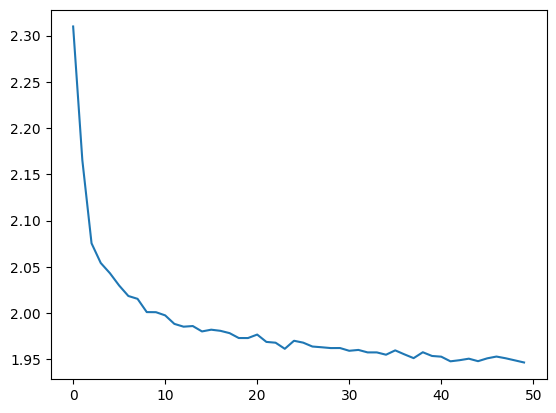

In [29]:
import matplotlib.pyplot as plt

epoch = range(0,len(loss_list))
plt.plot(epoch, loss_list)
plt.show()

In [30]:
# epoch = range(0,40)
# plt.plot(epoch, mse_loss_list)
# plt.show()

In [31]:
import numpy as np

def CalcHammingDist(B1, B2):
    q = B2.shape[1]
    distH = 0.5 * (q - np.dot(B1, B2.transpose()))
    return distH

def CalcMap(qB, rB, queryL, retrievalL):
    num_query = queryL.shape[0]
    map = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        tsum = np.sum(gnd)
        if tsum == 0:
            continue
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(gnd == 1)) + 1.0
        map_ = np.mean(count / (tindex))
        map = map + map_
    map = map / num_query
    return map

def CalcTopMap(qB, rB, queryL, retrievalL, topk):
    num_query = queryL.shape[0]
    topkmap = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        tgnd = gnd[0:topk]
        tsum = np.sum(tgnd)
        if tsum == 0:
            continue
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(tgnd == 1)) + 1.0
        topkmap_ = np.mean(count / (tindex))
        topkmap = topkmap + topkmap_
    topkmap = topkmap / num_query
    return topkmap


In [32]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10_test = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train = False)

testloader = DataLoader(CIFAR10_test, batch_size= 256,shuffle= True)

Files already downloaded and verified


In [33]:
list = []
labels_list = []
for images, labels in testloader:

    images = images.to(device)
    labels = labels.to(device)

    alexnet_mod.eval()
    U  = alexnet_mod(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

qB = np.concatenate(list, axis = 0)
test_labels = np.concatenate(labels_list, axis = 0)

In [34]:
list = []
labels_list = []
for images, labels in dataloader:

    images = images.to(device)
    labels = labels.to(device)

    alexnet_mod.eval()
    U  = alexnet_mod(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

rB = np.concatenate(list, axis = 0)
train_labels = np.concatenate(labels_list)

In [35]:
qB.shape

(10000, 16)

In [36]:
CalcMap(qB, rB, test_labels, train_labels)

0.1655177343962286

In [37]:
topk = 15
CalcTopMap(qB, rB, test_labels, train_labels, topk)

0.32898788790366196